In [45]:
import torch
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio


In [23]:
image_size = 64
label_dim = 62
G_input_dim = 100
G_output_dim = 1
D_input_dim = 1
D_output_dim = 1
num_filters = [1024, 512, 256, 128]

In [46]:
# learning_rate = 0.0002
learning_rate = 0.001
betas = (0.5, 0.999)
batch_size = 128
num_epochs = 20
data_dir = './data'

In [25]:
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [26]:
mnist_data = dsets.EMNIST(root='data',
                         train=True,
                         split='balanced',
                         transform=transform,
                         download=False)

In [27]:
from IPython.display import Image, display


In [28]:
mnist_data[3050]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]), 7)

In [29]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True)

In [30]:
cnt = 0
for item, label in data_loader:
    if (label != 0):
        continue
    print(item)
    cnt += 1
    if cnt > 100:
        break

RuntimeError: bool value of Tensor with more than one value is ambiguous

In [31]:
splits = ('byclass', 'bymerge', 'balanced', 'letters', 'digits', 'mnist')

In [32]:
def read_sn3_pascalvincent_tensor(path, strict=True):
    """Read a SN3 file in "Pascal Vincent" format (Lush file 'libidx/idx-io.lsh').
       Argument may be a filename, compressed filename, or file object.
    """
    # typemap
    if not hasattr(read_sn3_pascalvincent_tensor, 'typemap'):
        read_sn3_pascalvincent_tensor.typemap = {
            8: (torch.uint8, np.uint8, np.uint8),
            9: (torch.int8, np.int8, np.int8),
            11: (torch.int16, np.dtype('>i2'), 'i2'),
            12: (torch.int32, np.dtype('>i4'), 'i4'),
            13: (torch.float32, np.dtype('>f4'), 'f4'),
            14: (torch.float64, np.dtype('>f8'), 'f8')}
    # read
    with open_maybe_compressed_file(path) as f:
        data = f.read()
    # parse
    magic = get_int(data[0:4])
    nd = magic % 256
    ty = magic // 256
    assert nd >= 1 and nd <= 3
    assert ty >= 8 and ty <= 14
    m = read_sn3_pascalvincent_tensor.typemap[ty]
    s = [get_int(data[4 * (i + 1): 4 * (i + 2)]) for i in range(nd)]
    parsed = np.frombuffer(data, dtype=m[1], offset=(4 * (nd + 1)))
    assert parsed.shape[0] == np.prod(s) or not strict
    return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)

In [33]:

def open_maybe_compressed_file(path):
    """Return a file object that possibly decompresses 'path' on the fly.
       Decompression occurs when argument `path` is a string and ends with '.gz' or '.xz'.
    """
    if not isinstance(path, torch._six.string_classes):
        return path
    if path.endswith('.gz'):
        import gzip
        return gzip.open(path, 'rb')
    if path.endswith('.xz'):
        import lzma
        return lzma.open(path, 'rb')
    return open(path, 'rb')

def read_image_file(path):
    with open(path, 'rb') as f:
        x = read_sn3_pascalvincent_tensor(f, strict=False)
    assert(x.dtype == torch.uint8)
    assert(x.ndimension() == 3)
    return x


In [34]:
import codecs
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [35]:
def read_label_file(path):
    with open(path, 'rb') as f:
        x = read_sn3_pascalvincent_tensor(f, strict=False)
    assert(x.dtype == torch.uint8)
    assert(x.ndimension() == 1)
    return x.long()

In [36]:
# for split in splits:
#     training_set = (
#         read_image_file(f'data/EMNIST/raw/gzip/emnist-{split}-train-images-idx3-ubyte'),
#         read_label_file(f'data/EMNIST/raw/gzip/emnist-{split}-train-labels-idx1-ubyte')
#     )
#     test_set = (
#         read_image_file(f'data/EMNIST/raw/gzip/emnist-{split}-test-images-idx3-ubyte'),
#         read_label_file(f'data/EMNIST/raw/gzip/emnist-{split}-test-labels-idx1-ubyte')
#     )
#     with open(f'data/EMNIST/processed/training_{split}.pt', 'wb') as f:
#         torch.save(training_set, f)
#     with open(f'data/EMNIST/processed/test_{split}.pt', 'wb') as f:
#         torch.save(test_set, f)

In [37]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)


# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [38]:

# Generator model
class Generator(torch.nn.Module):
    def __init__(self, input_dim, label_dim, num_filters, output_dim):
        super(Generator, self).__init__()

        # Hidden layers
        self.hidden_layer1 = torch.nn.Sequential()
        self.hidden_layer2 = torch.nn.Sequential()
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Deconvolutional layer
            if i == 0:
                # For input
                input_deconv = torch.nn.ConvTranspose2d(input_dim, int(num_filters[i]/2), kernel_size=4, stride=1, padding=0)
                self.hidden_layer1.add_module('input_deconv', input_deconv)

                # Initializer
                torch.nn.init.normal(input_deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant(input_deconv.bias, 0.0)

                # Batch normalization
                self.hidden_layer1.add_module('input_bn', torch.nn.BatchNorm2d(int(num_filters[i]/2)))

                # Activation
                self.hidden_layer1.add_module('input_act', torch.nn.ReLU())

                # For label
                label_deconv = torch.nn.ConvTranspose2d(label_dim, int(num_filters[i]/2), kernel_size=4, stride=1, padding=0)
                self.hidden_layer2.add_module('label_deconv', label_deconv)

                # Initializer
                torch.nn.init.normal(label_deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant(label_deconv.bias, 0.0)

                # Batch normalization
                self.hidden_layer2.add_module('label_bn', torch.nn.BatchNorm2d(int(num_filters[i]/2)))

                # Activation
                self.hidden_layer2.add_module('label_act', torch.nn.ReLU())
            else:
                deconv = torch.nn.ConvTranspose2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

                deconv_name = 'deconv' + str(i + 1)
                self.hidden_layer.add_module(deconv_name, deconv)

                # Initializer
                torch.nn.init.normal(deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant(deconv.bias, 0.0)

                # Batch normalization
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

                # Activation
                act_name = 'act' + str(i + 1)
                self.hidden_layer.add_module(act_name, torch.nn.ReLU())

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Deconvolutional layer
        out = torch.nn.ConvTranspose2d(num_filters[i], output_dim, kernel_size=4, stride=2, padding=1)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Tanh())

    def forward(self, z, c):
        h1 = self.hidden_layer1(z)
        h2 = self.hidden_layer2(c)
        x = torch.cat([h1, h2], 1)
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out

In [39]:
# Discriminator model
class Discriminator(torch.nn.Module):
    def __init__(self, input_dim, label_dim, num_filters, output_dim):
        super(Discriminator, self).__init__()

        self.hidden_layer1 = torch.nn.Sequential()
        self.hidden_layer2 = torch.nn.Sequential()
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Convolutional layer
            if i == 0:
                # For input
                input_conv = torch.nn.Conv2d(input_dim, int(num_filters[i]/2), kernel_size=4, stride=2, padding=1)
                self.hidden_layer1.add_module('input_conv', input_conv)

                # Initializer
                torch.nn.init.normal(input_conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant(input_conv.bias, 0.0)

                # Activation
                self.hidden_layer1.add_module('input_act', torch.nn.LeakyReLU(0.2))

                # For label
                label_conv = torch.nn.Conv2d(label_dim, int(num_filters[i]/2), kernel_size=4, stride=2, padding=1)
                self.hidden_layer2.add_module('label_conv', label_conv)

                # Initializer
                torch.nn.init.normal(label_conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant(label_conv.bias, 0.0)

                # Activation
                self.hidden_layer2.add_module('label_act', torch.nn.LeakyReLU(0.2))
            else:
                conv = torch.nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

                conv_name = 'conv' + str(i + 1)
                self.hidden_layer.add_module(conv_name, conv)

                # Initializer
                torch.nn.init.normal(conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant(conv.bias, 0.0)

                # Batch normalization
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

                # Activation
                act_name = 'act' + str(i + 1)
                self.hidden_layer.add_module(act_name, torch.nn.LeakyReLU(0.2))

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Convolutional layer
        out = torch.nn.Conv2d(num_filters[i], output_dim, kernel_size=4, stride=1, padding=0)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Sigmoid())

    def forward(self, z, c):
        h1 = self.hidden_layer1(z)
        h2 = self.hidden_layer2(c)
        x = torch.cat([h1, h2], 1)
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out

In [40]:
# Plot losses
def plot_loss(d_losses, g_losses, num_epoch, save=False, save_dir='MNIST_cDCGAN_results/', show=False):
    fig, ax = plt.subplots()
    ax.set_xlim(0, num_epochs)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses))*1.1)
    plt.xlabel('Epoch {0}'.format(num_epoch + 1))
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'MNIST_cDCGAN_losses_epoch_{:d}'.format(num_epoch + 1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

In [41]:
def plot_result(generator, noise, label, num_epoch, save=False, save_dir='MNIST_cDCGAN_results/', show=False, fig_size=(5, 5)):
    generator.eval()

    noise = Variable(noise.cuda())
    label = Variable(label.cuda())
    gen_image = generator(noise, label)
    gen_image = denorm(gen_image)

    generator.train()

    n_rows = np.sqrt(noise.size()[0]).astype(np.int32)
    n_cols = np.sqrt(noise.size()[0]).astype(np.int32)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    for ax, img in zip(axes.flatten(), gen_image):
        ax.axis('off')
#         ax.set_adjustable('box-forced')
        ax.imshow(img.cpu().data.view(image_size, image_size).numpy(), cmap='gray', aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    title = 'Epoch {0}'.format(num_epoch+1)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'MNIST_cDCGAN_epoch_{:d}'.format(num_epoch+1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

In [42]:
# Models
G = Generator(G_input_dim, label_dim, num_filters, G_output_dim)
D = Discriminator(D_input_dim, label_dim, num_filters[::-1], D_output_dim)
G.cuda()
D.cuda()


/home/will/anaconda3/envs/bleedingedge/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/will/anaconda3/envs/bleedingedge/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/home/will/anaconda3/envs/bleedingedge/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/will/anaconda3/envs/bleedingedge/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/home/will/anaconda3/envs/bleedingedge/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/will/anaconda3/envs/bleedingedge/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: nn.init.constant is now deprecated in favor of

Discriminator(
  (hidden_layer1): Sequential(
    (input_conv): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (input_act): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer2): Sequential(
    (label_conv): Conv2d(62, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (label_act): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer): Sequential(
    (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): LeakyReLU(negative_slope=0.2)
    (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): LeakyReLU(negative_slope=0.2)
    (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act4): LeakyRe

In [43]:
# Loss function
criterion = torch.nn.BCELoss()

# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=betas)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate/2, betas=betas)

# Training GAN
D_avg_losses = []
G_avg_losses = []

# # Fixed noise & label for test
# num_test_samples = 10*10

# temp_noise = torch.randn(label_dim, G_input_dim)
# fixed_noise = temp_noise
# fixed_c = torch.zeros(label_dim, 1)
# for i in range(9):
#     fixed_noise = torch.cat([fixed_noise, temp_noise], 0)
#     temp = torch.ones(label_dim, 1) + i
#     fixed_c = torch.cat([fixed_c, temp], 0)

# fixed_noise = fixed_noise.view(-1, G_input_dim, 1, 1)
# fixed_label = torch.zeros(G_input_dim, label_dim)
# print('fixed_c:', fixed_c.shape)
# fixed_label.scatter_(1, fixed_c.type(torch.LongTensor), 1)
# fixed_label = fixed_label.view(-1, label_dim, 1, 1)
# fixed noise & label

# Label preprocess
onehot = torch.zeros(label_dim, label_dim)
onehot = onehot.scatter_(1, torch.LongTensor(list(range(62))).view(label_dim, 1), 1).view(label_dim, label_dim, 1, 1)
fill = torch.zeros([label_dim, label_dim, image_size, image_size])
for i in range(label_dim):
    fill[i, i, :, :] = 1

temp_noise0_ = torch.randn(4, G_input_dim)
temp_noise0_ = torch.cat([temp_noise0_, temp_noise0_], 0)
temp_noise1_ = torch.randn(4, G_input_dim)
temp_noise1_ = torch.cat([temp_noise1_, temp_noise1_], 0)

fixed_noise = torch.cat([temp_noise0_, temp_noise1_], 0)
fixed_label = torch.cat([torch.zeros(4), torch.ones(4), torch.zeros(4), torch.ones(4)], 0).type(torch.LongTensor).squeeze()

fixed_noise = fixed_noise.view(-1, G_input_dim, 1, 1)
fixed_label = onehot[fixed_label]

# # label preprocess
# onehot = torch.zeros(label_dim, label_dim)
# onehot = onehot.scatter_(1, torch.LongTensor(list(range(62))).view(label_dim, 1), 1).view(label_dim, label_dim, 1, 1)
# fill = torch.zeros([label_dim, label_dim, image_size, image_size])
# for i in range(label_dim):
#     fill[i, i, :, :] = 1

In [47]:
step = 0
for epoch in range(num_epochs):
    D_losses = []
    G_losses = []

    if epoch == 5 or epoch == 10:
        G_optimizer.param_groups[0]['lr'] /= 2
        D_optimizer.param_groups[0]['lr'] /= 2

    # minibatch training
    for i, (images, labels) in enumerate(data_loader):
#         print(images.size())
#         print(labels.size())
        # image data
        mini_batch = images.size()[0]
        x_ = Variable(images.cuda())

        # labels
        y_real_ = Variable(torch.ones(mini_batch).cuda())
        y_fake_ = Variable(torch.zeros(mini_batch).cuda())
        c_fill_ = Variable(fill[labels].cuda())

        # Train discriminator with real data
        D_real_decision = D(x_, c_fill_).squeeze()
        D_real_loss = criterion(D_real_decision, y_real_)

        # Train discriminator with fake data
        z_ = torch.randn(mini_batch, G_input_dim).view(-1, G_input_dim, 1, 1)
        z_ = Variable(z_.cuda())

        c_ = (torch.rand(mini_batch, 1) * label_dim).type(torch.LongTensor).squeeze()
        c_onehot_ = Variable(onehot[c_].cuda())
        gen_image = G(z_, c_onehot_)

        c_fill_ = Variable(fill[c_].cuda())
        D_fake_decision = D(gen_image, c_fill_).squeeze()
        D_fake_loss = criterion(D_fake_decision, y_fake_)

        # Back propagation
        D_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        z_ = torch.randn(mini_batch, G_input_dim).view(-1, G_input_dim, 1, 1)
        z_ = Variable(z_.cuda())

        c_ = (torch.rand(mini_batch, 1) * label_dim).type(torch.LongTensor).squeeze()
        c_onehot_ = Variable(onehot[c_].cuda())
        gen_image = G(z_, c_onehot_)

        c_fill_ = Variable(fill[c_].cuda())
        D_fake_decision = D(gen_image, c_fill_).squeeze()
        G_loss = criterion(D_fake_decision, y_real_)

        # Back propagation
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # loss values
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
              % (epoch+1, num_epochs, i+1, len(data_loader), D_loss.item(), G_loss.item()))

        # ============ TensorBoard logging ============#
#         D_logger.scalar_summary('losses', D_loss.item(), step + 1)
#         G_logger.scalar_summary('losses', G_loss.item(), step + 1)
        step += 1

    D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    plot_loss(D_avg_losses, G_avg_losses, epoch, save=True)

    # Show result for fixed noise
    plot_result(G, fixed_noise, fixed_label, epoch, save=True)

Epoch [1/20], Step [1/882], D_loss: 0.0000, G_loss: 16.4020
Epoch [1/20], Step [2/882], D_loss: 0.0000, G_loss: 14.3330
Epoch [1/20], Step [3/882], D_loss: 0.0000, G_loss: 14.3964
Epoch [1/20], Step [4/882], D_loss: 0.0001, G_loss: 16.9820
Epoch [1/20], Step [5/882], D_loss: 0.0000, G_loss: 15.9402
Epoch [1/20], Step [6/882], D_loss: 0.0000, G_loss: 18.1645
Epoch [1/20], Step [7/882], D_loss: 0.0000, G_loss: 11.2658
Epoch [1/20], Step [8/882], D_loss: 0.0000, G_loss: 11.3848
Epoch [1/20], Step [9/882], D_loss: 0.0000, G_loss: 15.7519
Epoch [1/20], Step [10/882], D_loss: 0.0000, G_loss: 14.3060
Epoch [1/20], Step [11/882], D_loss: 0.0000, G_loss: 14.6856
Epoch [1/20], Step [12/882], D_loss: 0.0000, G_loss: 13.0626
Epoch [1/20], Step [13/882], D_loss: 0.0000, G_loss: 14.2774
Epoch [1/20], Step [14/882], D_loss: 0.0000, G_loss: 13.7473
Epoch [1/20], Step [15/882], D_loss: 0.0000, G_loss: 13.2507
Epoch [1/20], Step [16/882], D_loss: 0.0000, G_loss: 16.5132
Epoch [1/20], Step [17/882], D_lo

KeyboardInterrupt: 

In [ ]:
dsets.read_label

In [ ]:
import ctgan

In [70]:
Z_raw = torch.randn(mini_batch, G_input_dim).view(-1, G_input_dim, 1, 1)
Z = Variable(Z_raw.cuda())

C_raw = (torch.rand(mini_batch, 1) * label_dim).type(torch.LongTensor).squeeze()
# C_raw = (torch.ones(mini_batch) * label_dim).type(torch.LongTensor).squeeze()
# C_raw = torch.ones((128,)).type(torch.LongTensor)
print(C_raw.shape)
C = Variable(onehot[C_raw].cuda())
gen_image = G(Z, C)
cpu_gen_img = gen_image.detach().cpu()

torch.Size([128])


In [60]:
gen_image.shape

torch.Size([128, 1, 64, 64])

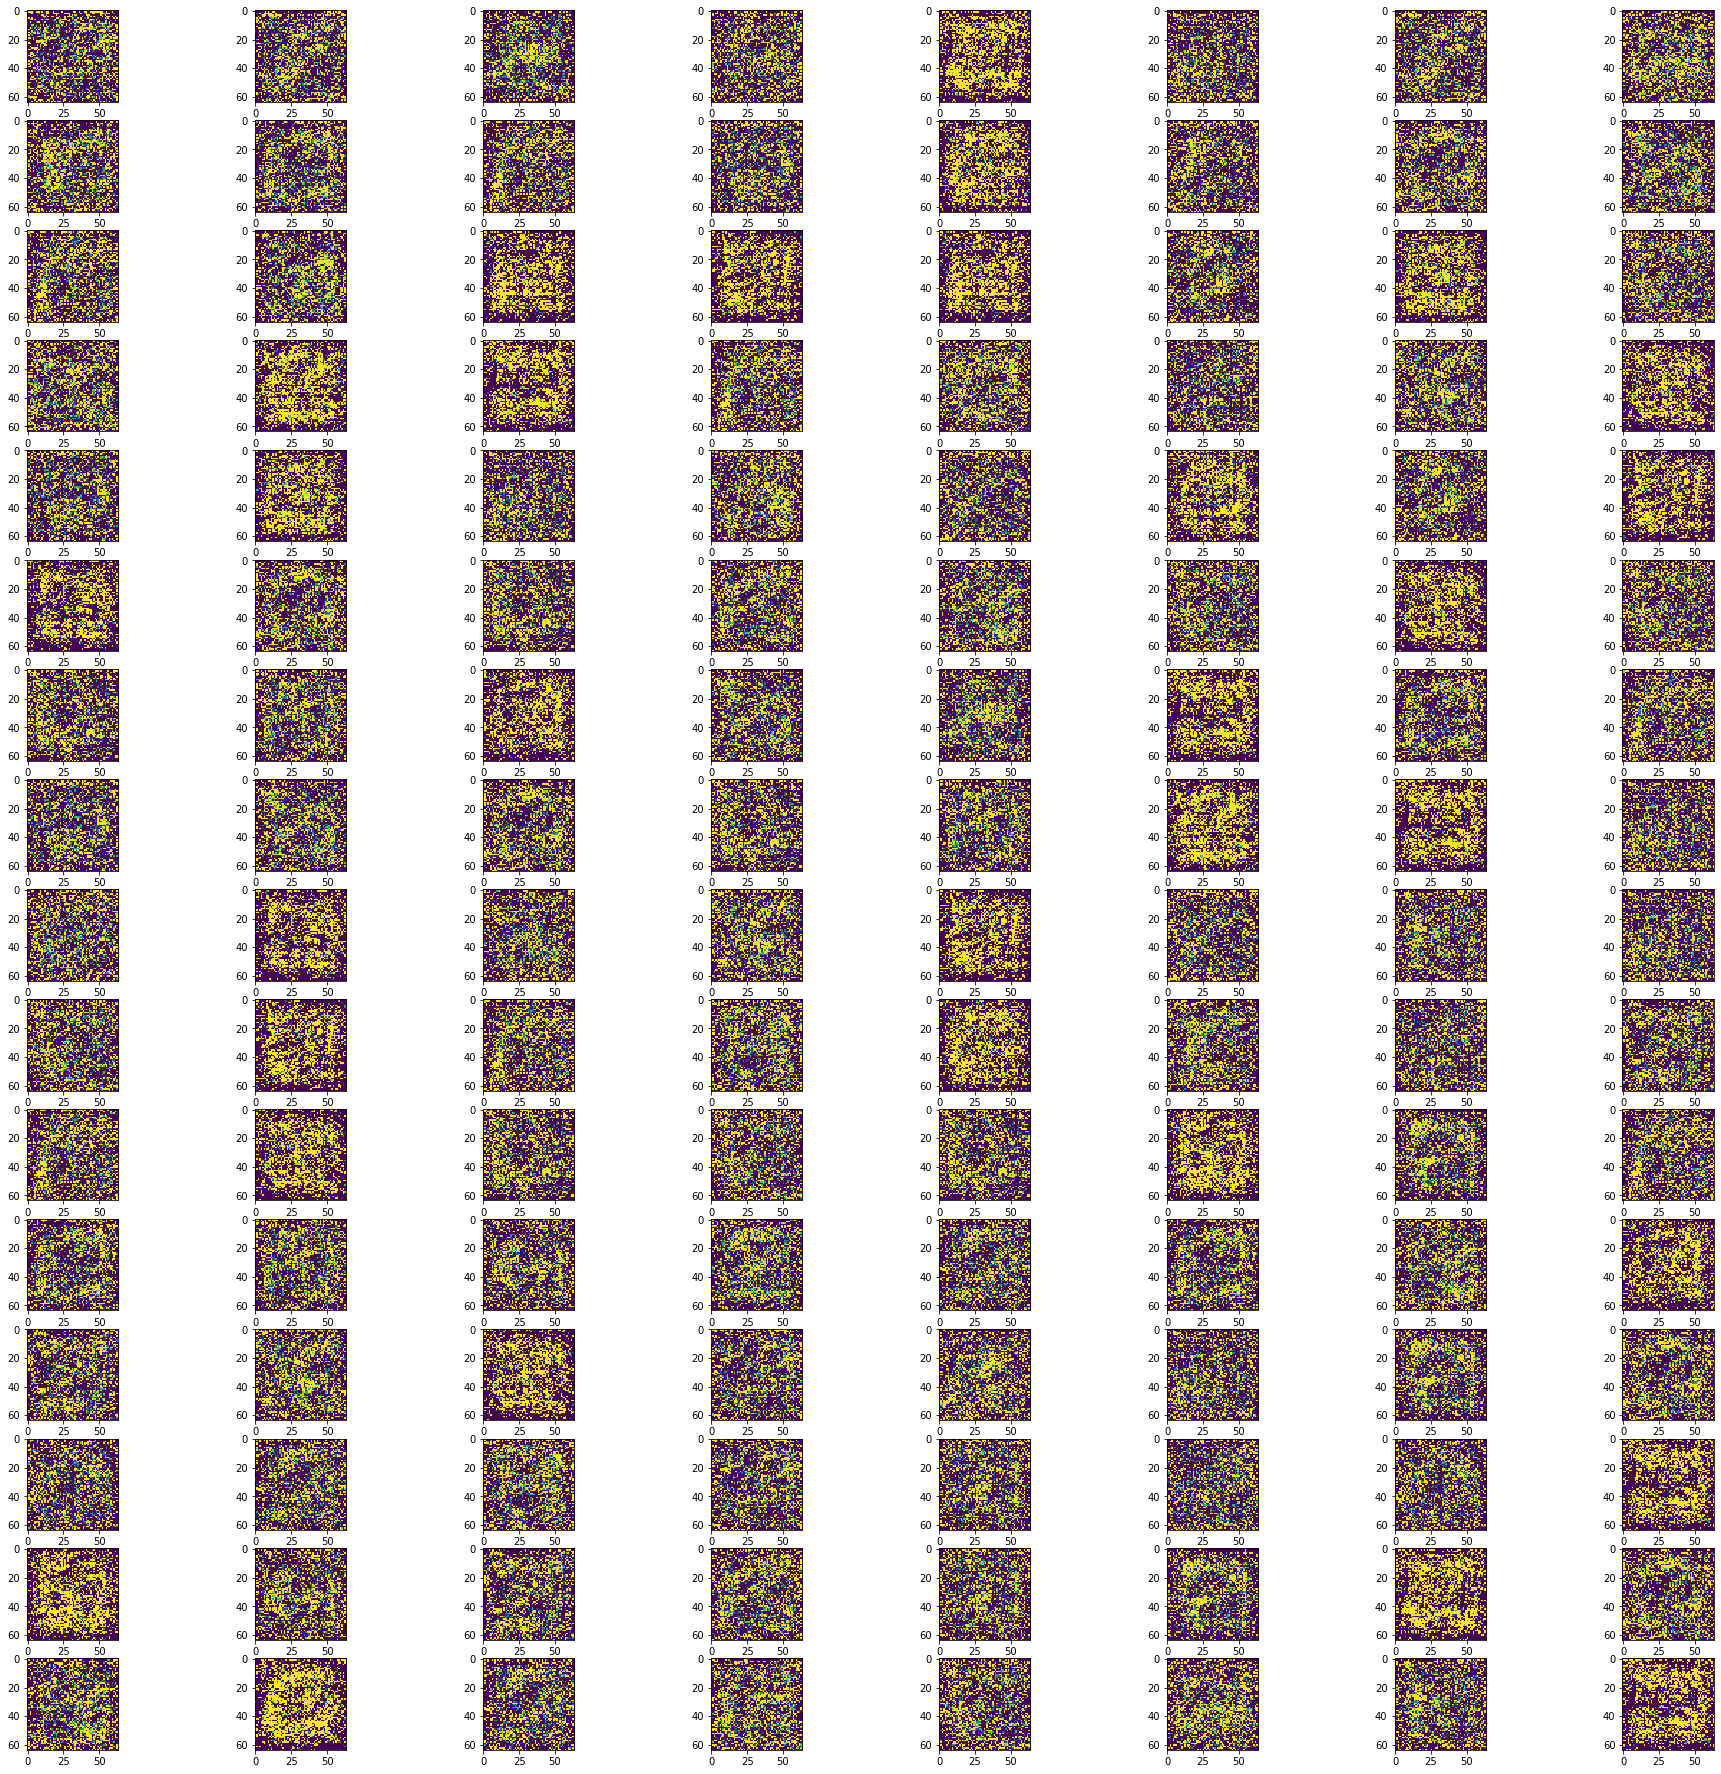

In [71]:
import numpy as np
import matplotlib.pyplot as plt

w=10
h=10
fig=plt.figure(figsize=(32, 32))
columns = 8
rows = 16
for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(cpu_gen_img[i-1, 0, :, :].view((64,64)))
plt.show()